In [30]:
import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

from snaptools import simulation
from snaptools import snapshot
from snaptools import combine_gals
from snaptools import manipulate as man
from snaptools import utils
from snaptools import plot_tools
from scipy import stats
import scipy.integrate as integrate

import astropy.units as u
from astropy import constants
import sys
import  moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import conversions as co
from snaptools import convert
import datetime
from PIL import Image
from astropy.io import fits
import glob
import IPython.display as display
import h5py
import pNbody as pnb

%matplotlib inline

In [96]:
class Caption():

    def __init__(self, s, n=1):
        self.s = s
        self.fig_num = n

    def _repr_html_(self):
        return 'Fig. {:d}: {:s}'.format(self.fig_num, self.s)

    def _repr_latex_(self):
        return 'Fig. {:d}: {:s}'.format(self.fig_num, self.s)


In [2]:
def today():
    return datetime.date.today().strftime('%B%d')


## Definitions of hot halo etc

In [6]:
def ram_pressure(rho, rel_vel):
    return 0.5*rho*rel_vel**2


def hot_halo(r, rhov, c, rs):
    x = r/rs
    return rhov*(1 + 3.7/x*np.log(1. + x) - 3.7/c*np.log(1. + c))**1.5



In [11]:
def poly_string(poly_params):
    
    order = len(poly_params)
    string = ''
    for i, p in enumerate(poly_params):
        i += 1
        operator = ' + ' if p > 0 else ' - '
        power = '$^{:d}$'.format(order-i) if (order-i > 1) else ''
        symbol = 't' if (order-i > 0) else ''
        string += '{:s}{:2.2f}{:s}{:s}'.format(operator, np.abs(p), symbol, power)
        
    return string[3:]



## Analytic sim - 1D

In [98]:
folder = '../Data/output_stream_fixed/'
snapshots = glob.glob(folder+'snapshot.csv.*')

lmc = np.empty((len(snapshots), 10))
smc = np.empty((len(snapshots), 10))

for i, snap in enumerate(snapshots):
    names = np.loadtxt(snap, skiprows=1, delimiter=",", usecols=(0,), dtype='S4')
    d = np.loadtxt(snap, skiprows=1, delimiter=",",  usecols=(range(1,11)))
    smc[i, :] = d[names == 'SMC', :]
    lmc[i, :] = d[names == 'LMC', :]

In [99]:
r1 = np.sqrt(np.sum(lmc[:, :3]**2, axis=1))*u.kpc
v1 = np.sqrt(np.sum(lmc[:, 3:6]**2, axis=1))*(u.km/u.s)

In [100]:
#MW values from Kupper et al. 2015
c = 5.14
M200 = 1.56E+12*u.solMass
r200 = 194.8*u.kpc
rs = r200/c
print rs

const = 2273.89

rhov=const*u.solMass/u.kpc**3

37.8988326848 kpc


In [101]:
hot_halo(200*u.kpc, rhov, c, rs).to(u.g/(u.cm**3))

<Quantity 1.4970254788475196e-28 g / cm3>

In [102]:
rho = hot_halo(r1, rhov, c, rs).to(u.g/u.cm**3)
rp = ram_pressure(rho, v1)

In [103]:
time = -1*lmc[:, 9]

deltaT = 2.
begin_time = time[np.min(np.where(r1.value > 75)[0])]
print begin_time
use = np.where((time > begin_time)*(time < begin_time+deltaT))

0.2501


In [106]:
density_conversion = (1.*u.g/(u.cm**3)).to(u.solMass/(u.kpc**3))

In [107]:
vel_params = np.polyfit(time[use], v1[use].value, 2)
vel_poly = np.poly1d(vel_params)

r_params = np.polyfit(time[use], r1[use].value, 2)
r_poly = np.poly1d(r_params)

rho_params = np.polyfit(time[use], rho[use].value, 3)
rho_poly = np.poly1d(rho_params)

rho_params = np.polyfit(time[use], rho[use].value*1e+28, 3)
rho_poly = np.poly1d(rho_params)

<__main__.Caption instance at 0x7f362a5b5878>

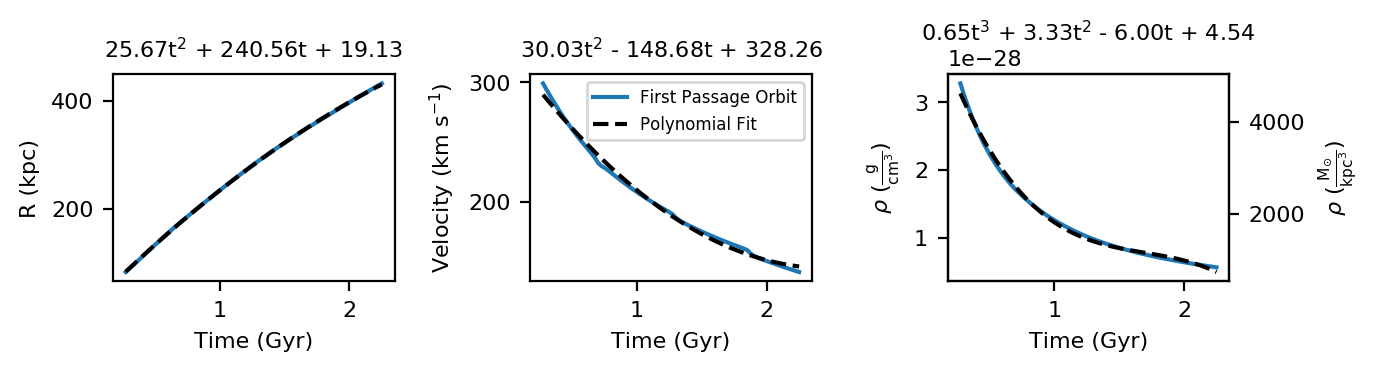

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2), dpi=200)

fontsize=8

axis = axes[0]

axis.plot(time[use], r1[use])
axis.plot(time[use], r_poly(time[use]), color='black', linestyle='--')

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel('R (kpc)')

axis.set_title(poly_string(r_params))

axis = axes[1]

axis.plot(time[use], v1[use], label='First Passage Orbit')
axis.plot(time[use], vel_poly(time[use]), color='black', linestyle='--', label='Polynomial Fit')

axis.legend(fontsize=fontsize-2)

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel(r'Velocity (km s$^{-1}$)')

axis.set_title(poly_string(vel_params))

axis = axes[2]

axis.plot(time[use], rho[use])
axis.plot(time[use], rho_poly(time[use])*1e-28, color='black', linestyle='--')

#axis.set_yscale('log')

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel(r'$\rho$ ({:s})'.format(rho[0].unit.to_string('latex')))

axis.set_title(poly_string(rho_params), y=1.08)

ax2 = axis.twinx()
mn, mx = axis.get_ylim()
ax2.set_ylim(mn*density_conversion.value, mx*density_conversion.value)
ax2.set_ylabel(r'$\rho$ ({:s})'.format(density_conversion.unit.to_string('latex')))

for ax in np.append(axes, ax2):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.offsetText] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
        
fig.tight_layout()

caption_text = """Polynomial fits to the distance, velocity, and density along a 1-D LMC orbit."""

display.display(Caption(caption_text, 1))


## Full 3D

In [15]:
SIMTYPE = 'rotate'
base_folder = '/usr/users/spardy/coors2/working/Magellanic_Stream/first_passage/Besla12'
output_folder = '/With_MW/output_first_passage_{:s}/'.format(SIMTYPE)

folder = base_folder + output_folder

sim_wMW = simulation.Simulation(folder)

with h5py.File('{:s}{:s}computed_positions.hdf5'.format(base_folder, output_folder)) as f:
    lmc_wMW = f['Halo/lmc'][:]
    smc_wMW = f['Halo/smc'][:]
    times_wMW = f['Halo/time'][:]
    lmc_vel_wMW = f['Disk/lmc_vel'][:]
    smc_vel_wMW = f['Disk/smc_vel'][:]
    
iMW = 99

In [16]:
# tools to rotate snapshots so that x-y plane is the main plane of the galaxy


def get_principal_axis(snap, parttype, idx=None, L=None ):
    """
    Get the principal axis for a galaxy
    """
    tensor = np.zeros((3, 3))

    if idx is not None:
        mass = snap.masses[parttype][idx]
        px = snap.pos[parttype][idx, 0]
        py = snap.pos[parttype][idx, 1]
        pz = snap.pos[parttype][idx, 2]
    else:
        mass = snap.masses[parttype]
        px = snap.pos[parttype][:, 0]
        py = snap.pos[parttype][:, 1]
        pz = snap.pos[parttype][:, 2]

    tensor[0, 0] = (mass * (py*py + pz*pz)).sum()
    tensor[1, 1] = (mass * (px*px + pz*pz)).sum()
    tensor[2, 2] = (mass * (px*px + py*py)).sum()

    tensor[0, 1] = - (mass * px * py).sum()
    tensor[1, 0] = tensor[0, 1]
    tensor[0, 2] = - (mass * px * pz).sum()
    tensor[2, 0] = tensor[0, 2]
    tensor[1, 2] = - (mass * py * pz).sum()
    tensor[2, 1] = tensor[1, 2]

    eigval, eigvec = np.linalg.eig(tensor)

    if L is None:
        maxval = eigval.argsort()[-1]
        return eigvec[:, maxval]
    else:
        A1 = (L * eigvec[:, 0]).sum()
        A2 = (L * eigvec[:, 1]).sum()
        A3 = (L * eigvec[:, 2]).sum()

        A = np.abs( np.array([A1, A2, A3]))
        i, = np.where(A == A.max())
        xdir = eigvec[:, i[0]]

        if (xdir * L).sum() < 0:
            xdir *= -1.0

        j, = np.where(A != A.max())
        i2 = eigval[j].argsort()
        ydir = eigvec[:, j[i2[1]]]

        if ydir[0] < 0:
            ydir *= -1.0

        zdir = np.cross(xdir, ydir)

        return xdir, ydir, zdir
    
def get_rotation(snap, idx=None, parttype='stars'):
    if idx is None:
        mass = snap.masses[parttype].astype('float64')
        L = np.cross(snap.pos[parttype].astype('float64'),
                    (snap.vel[parttype].astype('float64') * mass[:, None]))
    else:
        mass = snap.masses[parttype][idx].astype('float64')
        L = np.cross(snap.pos[parttype][idx, :].astype('float64'),
                    (snap.vel[parttype][idx, :].astype('float64') *
                     mass[:, None]))

    Ltot = L.sum(axis=0)
    Ldir = Ltot / np.sqrt((Ltot**2).sum())
    xdir, ydir, zdir = get_principal_axis(snap, parttype, idx=idx, L=Ldir)
    return xdir, ydir, zdir


def get_rotation_matrix(snapname):
    snap = snapshot.Snapshot(snapname, lazy=True)
    mass = snap.masses['stars']
    nstars = snap.header['nall'][2]
    lmc = np.where(mass == 2.5206771e-07)[0]
    rotation = get_rotation(snap, idx=lmc)
    rot_matrix = np.array(rotation, dtype=float)#.transpose()
    return rot_matrix
            

    

### Compute the velocity w.r.t the MW and rotated into the x-y plane

In [112]:
vel_rot = np.zeros_like(lmc_vel_wMW)
for i in xrange(len(vel_rot)):
    vel_rot[i, :] = np.dot(lmc_vel_wMW[i], get_rotation_matrix(sim_wMW.snaps[i]))

In [113]:
r = np.sqrt(np.sum(lmc_wMW**2, axis=1))

In [114]:
use = (np.append(np.diff(np.linalg.norm(lmc_wMW, axis=1)) < 0, False)*(r > 60))

In [115]:
time = -1*(times_wMW[use] - times_wMW[use][-1])

<__main__.Caption instance at 0x7f3629ac4830>

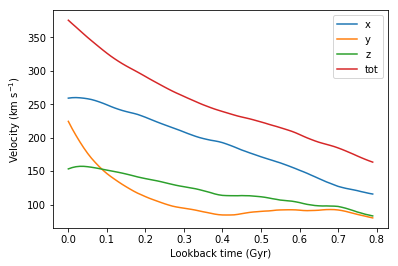

In [117]:
fig, axis = plt.subplots(1)

axis.plot(time, np.abs(vel_rot[use, 0]), label='x')
axis.plot(time, np.abs(vel_rot[use, 1]), label='y')
axis.plot(time, np.abs(vel_rot[use, 2]), label='z')

axis.plot(time, np.linalg.norm(vel_rot[use], axis=1), label='tot')
axis.legend()

axis.set_xlabel('Lookback time (Gyr)')
axis.set_ylabel('Velocity (km s$^{-1}$)')

caption_text = """Magnitude of the velocity in each component as a function of time."""

display.display(Caption(caption_text, 2))

In [119]:
r = np.sqrt(np.sum(lmc_wMW[use]**2, axis=1))*u.kpc
v = np.abs(vel_rot[use, 0])*(u.km/u.s)

In [120]:
#MW values from Kupper et al. 2015
model = 'Kupper+2015'
c = 5.14
M200 = 1.56E+12*u.solMass
r200 = 194.8*u.kpc
rs = r200/c
print rs

const = 2273.89

rhov=const*u.solMass/u.kpc**3

37.8988326848 kpc


In [23]:
#MW values from others
model = 'Fang+2013'
c = 12
M200 = 1.0E+12*u.solMass
r200 = 260.0*u.kpc
rs = r200/c
print rs

const = 2273.89

rhov=const*u.solMass/u.kpc**3

21.6666666667 kpc


In [121]:
"Mtot (R<200kpc) = {0.value:e} {0.unit:s}".format(integrate.quad(lambda x: hot_halo(x, rhov.value, c, rs.value),
                                                            0.1, 200)[0] * u.solMass)

'Mtot (R<200kpc) = 1.044895e+06 solMass'

In [122]:
rho = hot_halo(r, rhov, c, rs).to(u.g/u.cm**3)
rp = ram_pressure(rho, v)

In [123]:
vel_params = np.polyfit(time, v.value, 2)
vel_poly = np.poly1d(vel_params)

r_params = np.polyfit(time, r.value, 2)
r_poly = np.poly1d(r_params)

rho_params = np.polyfit(time, rho.value, 3)
rho_poly = np.poly1d(rho_params)

rho_params = np.polyfit(time, rho.value*1e+28, 3)
rho_poly = np.poly1d(rho_params)

<__main__.Caption instance at 0x7f3638ce90e0>

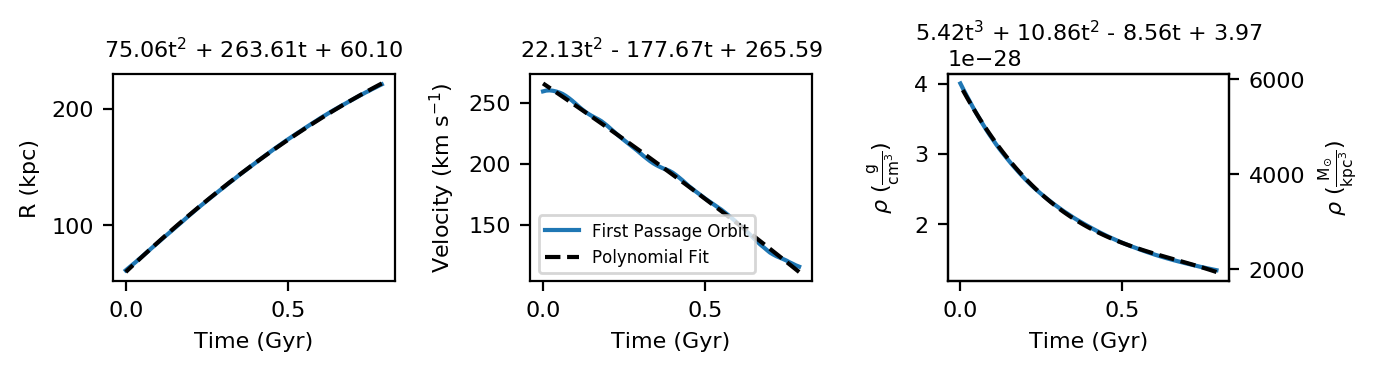

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2), dpi=200)

fontsize=8

axis = axes[0]

axis.plot(time, r)
axis.plot(time, r_poly(time), color='black', linestyle='--')

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel('R (kpc)')

axis.set_title(poly_string(r_params))

axis = axes[1]

axis.plot(time, v, label='First Passage Orbit')
axis.plot(time, vel_poly(time), color='black', linestyle='--', label='Polynomial Fit')

axis.legend(fontsize=fontsize-2)

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel(r'Velocity (km s$^{-1}$)')

axis.set_title(poly_string(vel_params))

axis = axes[2]

axis.plot(time, rho)
axis.plot(time, rho_poly(time)*1e-28, color='black', linestyle='--')

#axis.set_yscale('log')

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel(r'$\rho$ ({:s})'.format(rho[0].unit.to_string('latex')))

axis.set_title(poly_string(rho_params), y=1.08)

ax2 = axis.twinx()
mn, mx = axis.get_ylim()
ax2.set_ylim(mn*density_conversion.value, mx*density_conversion.value)
ax2.set_ylabel(r'$\rho$ ({:s})'.format(density_conversion.unit.to_string('latex')))

for ax in np.append(axes, ax2):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.offsetText] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
        
fig.tight_layout()

caption_text = """Polynomial fits to the distance, velocity, and density along the x-component of the 3-D LMC orbit.
Hot halo model from Fang+2013."""

display.display(Caption(caption_text, 3))

#fig.savefig("../../research_notes/{:s}/ram_pressure_fit_{:s}.pdf".format(today(), model),
#            dpi=200, bbox_inches='tight')

## Salem+2015

Salem et al. 2015 use a $\beta$-model originally from Makino et al. 1998. This model has three parameters $n_0$, $r_c$, and $\beta$. Salem+2015 fit these parameters by comparing the truncation radius of the LMC's HI disk generated by a semi-analytic model to observations.

In [125]:
def density_makino(r, n0=0.46, rc=0.35, beta=0.71):
    return n0*(1+(r/rc)**2)**(-3*beta/2.)


In [126]:
r_test = np.logspace(1.1, 2.3, 20)*u.kpc

In [127]:
# salem parameters 
n0_salem = 0.46*(1./u.cm**3)
rc_salem = 0.35*u.kpc
beta_salem = 0.559

<__main__.Caption instance at 0x7f3638fd8878>

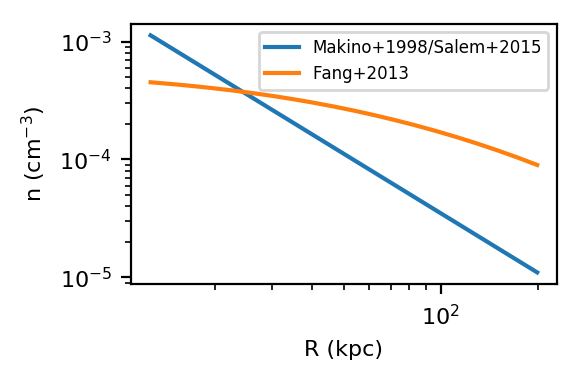

In [135]:
n_test = density_makino(r_test, n0=n0_salem, rc=rc_salem, beta=beta_salem)
rho_test = hot_halo(r_test, rhov, c, rs).to(u.g/u.cm**3)

fig, axis = plt.subplots(1, dpi=200, figsize=(3, 2))

axis.plot(r_test, n_test, label='Makino+1998/Salem+2015')
axis.plot(r_test, rho_test/(constants.m_p.to(u.g)), label='Fang+2013')

axis.set_yscale('log')
axis.set_xscale('log')

axis.legend(fontsize=fontsize-2)

axis.set_ylabel('n (cm$^{-3}$)')
axis.set_xlabel('R (kpc)')

for ax in [axis]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.offsetText] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
        
fig.tight_layout()

caption_text = """Comparison of the density used in Salem+2015 to the model favored by Fang+2013."""
display.display(Caption(caption_text, 4))


In [136]:
rho_salem = density_makino(r, n0=n0_salem, rc=rc_salem, beta=beta_salem)*constants.m_p.to(u.g)
rp_salem = ram_pressure(rho, v)

In [137]:
vel_params_salem = np.polyfit(time, v.value, 2)
vel_poly_salem = np.poly1d(vel_params_salem)

r_params_salem = np.polyfit(time, r.value, 2)
r_poly_salem = np.poly1d(r_params_salem)

rho_params_salem = np.polyfit(time, rho_salem.value*1e+28, 3)
rho_poly_salem = np.poly1d(rho_params_salem)

<__main__.Caption instance at 0x7f3638fa7200>

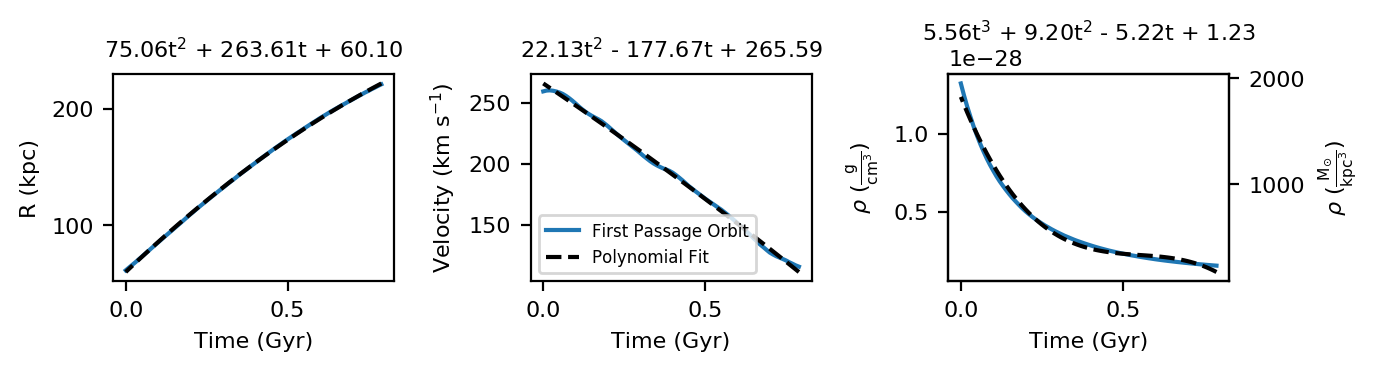

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2), dpi=200)

fontsize=8

axis = axes[0]

axis.plot(time, r)
axis.plot(time, r_poly_salem(time), color='black', linestyle='--')

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel('R (kpc)')

axis.set_title(poly_string(r_params_salem))

axis = axes[1]

axis.plot(time, v, label='First Passage Orbit')
axis.plot(time, vel_poly_salem(time), color='black', linestyle='--', label='Polynomial Fit')

axis.legend(fontsize=fontsize-2)

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel(r'Velocity (km s$^{-1}$)')

axis.set_title(poly_string(vel_params_salem))

axis = axes[2]

axis.plot(time, rho_salem)
axis.plot(time, rho_poly_salem(time)*1e-28, color='black', linestyle='--')

#axis.set_yscale('log')

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel(r'$\rho$ ({:s})'.format(rho_salem[0].unit.to_string('latex')))

axis.set_title(poly_string(rho_params_salem), y=1.08)

ax2 = axis.twinx()
mn, mx = axis.get_ylim()
ax2.set_ylim(mn*density_conversion.value, mx*density_conversion.value)
ax2.set_ylabel(r'$\rho$ ({:s})'.format(density_conversion.unit.to_string('latex')))

for ax in np.append(axes, ax2):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.offsetText] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
        
fig.tight_layout()

caption_text = """Polynomial fits to the distance, velocity, and density along the x-component of the 3-D LMC orbit.
Hot halo model from Salem+2015/Makino+1998."""
display.display(Caption(caption_text, 5))

#fig.savefig("../../research_notes/{:s}/ram_pressure_fit_{:s}.pdf".format(today(), model),
#            dpi=200, bbox_inches='tight')